In [1]:
import ast
import codecs
import json
import numpy as np
from keras.layers import Dense, InputLayer, Embedding, Activation, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])

        token_sequences.append(token_sequence)

    return token_sequences


def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


def get_words(sentences):
    words = set([])
    for sentence in sentences:
        for word in sentence:
            words.add(word)
    return words


def get_tags(sentences_tags):
    tags = set([])
    for tag in sentences_tags:
        for t in tag:
            tags.add(t)
    return tags


def get_train_sentences_x(train_sentences, word2index):
    train_sentences_x = []
    for sentence in train_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])

        train_sentences_x.append(sentence_index)
    return train_sentences_x


def get_test_sentences_x(test_sentences, word2index):
    test_sentences_x = []
    for sentence in test_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])
        test_sentences_x.append(sentence_index)
    return test_sentences_x


def get_train_tags_y(train_tags, tag2index):
    train_tags_y = []
    for tags in train_tags:
        train_tags_y.append([tag2index[t] for t in tags])
    return train_tags_y


def get_test_tags_y(test_tags, tag2index):
    test_tags_y = []
    for tags in test_tags:
        test_tags_y.append([tag2index[t] for t in tags])
    return test_tags_y


In [3]:
tagged_sentences = codecs.open("C:\\Users\\kingp\\Desktop\\URDU NER\\NER2\\sample.txt", encoding="utf-8").readlines()


print(tagged_sentences[6])
print("Tagged sentences: ", len(tagged_sentences))

words, tags = [], []


# Loop over each line in the dataset
for line in tagged_sentences:
    # Split the line into words and tags
    word_tag_pairs = line.strip().split(", ")
    # Extract the words and tags into separate lists
    words_line = [pair.split()[0] for pair in word_tag_pairs]
    tags_line = [pair.split()[1] for pair in word_tag_pairs]
    # Append the words and tags to the overall lists
    words.extend(words_line)
    tags.extend(tags_line)

# Convert the words and tags lists to NumPy arrays
sentences = np.array(words)
sentence_tags = np.array(tags)

(train_sentences,
 test_sentences,
 train_tags,
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

words = get_words(sentences)
tags = get_tags(sentence_tags)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1

tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

train_sentences_x = get_train_sentences_x(train_sentences, word2index)
test_sentences_x = get_test_sentences_x(test_sentences, word2index)

train_tags_y = get_train_tags_y(train_tags, tag2index)
test_tags_y = get_test_tags_y(test_tags, tag2index)

MAX_LENGTH = len(max(train_sentences_x, key=len))
# MAX_LENGTH = 181

train_sentences_x = pad_sequences(train_sentences_x, maxlen=MAX_LENGTH, padding='post')
test_sentences_x = pad_sequences(test_sentences_x, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH,)))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
history = model.fit(train_sentences_x, to_categorical(train_tags_y, len(tag2index)), batch_size=32, epochs=10,
                    validation_split=0.2).history
model.save("C:\\Users\\kingp\\Desktop\\URDU NER\\NER2\\lstm_ner.h5")
model.summary()

بھر	Other

Tagged sentences:  1676
Epoch 1/10
34/34 [==============================] - 3s 32ms/step - loss: 1.3305 - accuracy: 0.7173 - val_loss: 0.8214 - val_accuracy: 0.7290
Epoch 2/10
34/34 [==============================] - 1s 17ms/step - loss: 0.6989 - accuracy: 0.7342 - val_loss: 0.7061 - val_accuracy: 0.7308
Epoch 3/10
34/34 [==============================] - 1s 16ms/step - loss: 0.5768 - accuracy: 0.7638 - val_loss: 0.5856 - val_accuracy: 0.7816
Epoch 4/10
34/34 [==============================] - 1s 16ms/step - loss: 0.4470 - accuracy: 0.8350 - val_loss: 0.4514 - val_accuracy: 0.8771
Epoch 5/10
34/34 [==============================] - 1s 16ms/step - loss: 0.3208 - accuracy: 0.8948 - val_loss: 0.3367 - val_accuracy: 0.9267
Epoch 6/10
34/34 [==============================] - 1s 16ms/step - loss: 0.2235 - accuracy: 0.9425 - val_loss: 0.2562 - val_accuracy: 0.9747
Epoch 7/10
34/34 [==============================] - 1s 16ms/step - loss: 0.1595 - accuracy: 0.9855 - val_loss: 0.2097 -

In [4]:
scores = model.evaluate(test_sentences_x, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")  # acc: 98.39311069478103
print(test_sentences[0])
print(test_tags[0])
test_samples = [
    test_sentences[0],
]

test_samples_x = []
for sentence in test_samples:
    sentence_index = []
    for word in sentence:
        try:
            sentence_index.append(word2index[word])
        except KeyError:
            sentence_index.append(word2index['-OOV-'])
    test_samples_x.append(sentence_index)

test_samples_X = pad_sequences(test_samples_x, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

11/11 [==============================] - 0s 8ms/step - loss: 0.1273 - accuracy: 0.9834
accuracy: 98.33959937095642
حمایت‌علی
Person
1/1 [==============================] - 0s 378ms/step
[['O', 't', 'h', 'e', 'r', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-']]


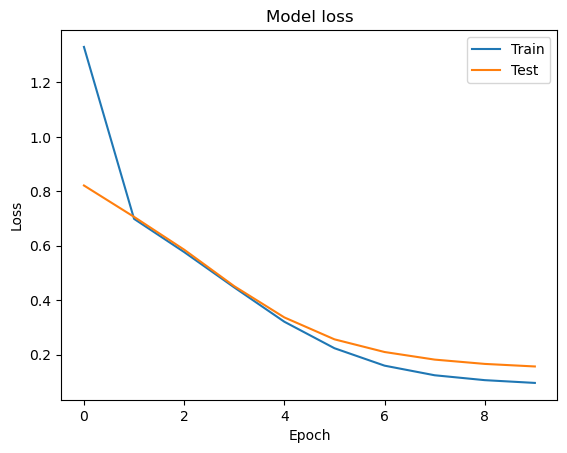

In [6]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

plt.clf()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
